# Predicting Daily Minimum Temperatures in Melbourne

In this time we will be using the [Daily Minimum Temperatures in Melbourne](https://github.com/jbrownlee/Datasets/blob/master/daily-min-temperatures.csv) dataset which contains data of the daily minimum temperatures recorded in Melbourne from 1981 to 1990. In addition to be using Tensorflow's layers for processing sequence data such as Recurrent layers or LSTMs you will also use Convolutional layers to improve the model's performance.

## Libraries

In [4]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Lambda, Conv1D, LSTM, Dense

In [5]:
TEMPERATURE_CSV = './daily-min-temperatures.csv'

In [6]:
# Reading the dataset
data = pd.read_csv(TEMPERATURE_CSV)
data.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


As you can see, each data point is composed of the date and the recorded minimum temperature for that date.

In [7]:
# Check the shape of the dataset
data.shape

(3650, 2)

In [8]:
# check the data types
data.dtypes

Date     object
Temp    float64
dtype: object

Next, we will create a function a helper function to plot the time series.


In [9]:
def plot_series(x, y, format='-',start=0, end=None, xlabel=None, ylabel=None,
                title=None, legend=None):
  """
    x (array of int) - contains values for the x-axis
    y (array of int or tuple of arrays) - contains the values for the y-axis
    format (string) - line style when plotting the graph
    start (int) - first time step to plot
    end (int) - last time step to plot
    title (string) - title of the plot
    xlabel (string) - label for the x-axis
    ylabel (string) - label for the y-axis
    legend (list of strings) - legend for the plot
  """
  # Setup dimensions of the figure
  plt.figure(figsize=(10,6))

  if type(y) is tuple:
    for y_num in y:
      plt.plot(x[start:end], y_num[start:end], format)

  else:
    plt.plot(x[start:end], y[start:end], format)

  # Set the x-axis label
  plt.xlabel(xlabel)

  # Set the y-axis label
  plt.ylabel(ylabel)

  # Set the title
  plt.title(title)

  #Set the legend
  if legend:
    plt.legend(legend)

  # Overlay a grid on the graph
  plt.grid(True)

  # Plot the graph
  plt.show()

Next, we will separate the features and labels. For the labels just we could consider the length of the Date column.

In [10]:
time = np.arange(len(data['Date']))
series = np.array(data['Temp'])

#Priting the shape of the time and series, they should be equal
print(time.shape)
print(series.shape)

(3650,)
(3650,)


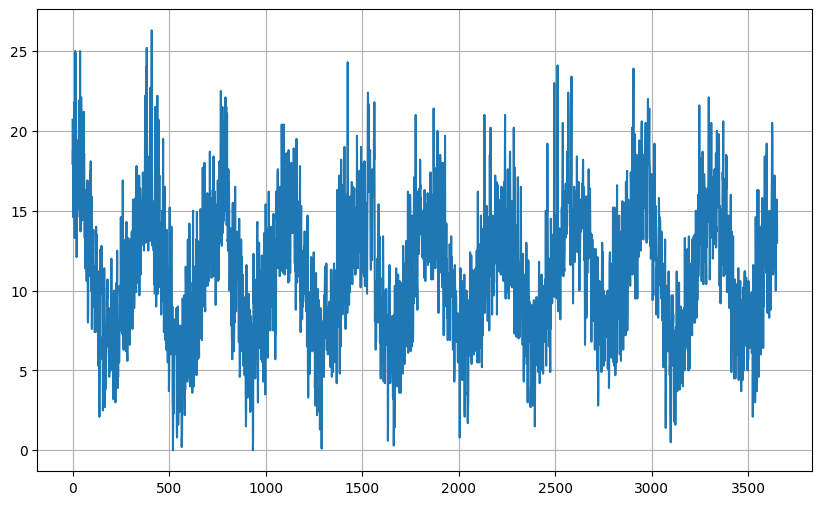

In [11]:
# Declaring some useful parameters and plotting the dataset.

SPLIT_TIME = 2500
WINDOW_SIZE = 64
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

plot_series(time,series)

## Processing the data

We will create some helper functions for splitting and window the data.

In [12]:
def train_test_split(time,series, SPLIT_TIME):

  # For training
  time_train = time[:SPLIT_TIME]
  series_train = series[:SPLIT_TIME]
  # For validation
  time_valid = time[SPLIT_TIME:]
  series_valid = series[SPLIT_TIME:]

  return time_train,series_train, time_valid, series_valid

In [13]:
# Apply the train_test_split function to the dataset

time_train,series_train, time_valid, series_valid = train_test_split(time,series,SPLIT_TIME)

In [14]:
def windowed_dataset(series, window_size, batch_size,shuffle_buffer):

  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(size=window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda w:w.batch(window_size+1))
  dataset = dataset.map(lambda w:(w[:-1],w[-1]))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [15]:
# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=WINDOW_SIZE, batch_size= BATCH_SIZE,
                             shuffle_buffer=SHUFFLE_BUFFER_SIZE)

### Defining the model architecture

In [16]:
#Derclaring some usesful variables
FILTERS=64
KERNEL_SIZE=3
STRIDES=1

In [17]:
def create_model():
  model = Sequential([
      Conv1D(filters=FILTERS, kernel_size=KERNEL_SIZE, strides=STRIDES, padding='causal',
             activation='relu' ,input_shape=[WINDOW_SIZE,1]),
      LSTM(128, return_sequences=True),
      LSTM(128, return_sequences=True),
      LSTM(64),
      Dense(32, activation='relu'),
      Dense(16, activation='relu'),
      Dense(1)
  ])
  return model

In [18]:
# Testing the model

# Create an instance of the model
model = create_model()

# Get one batch of the training set(X = input, y = label)
for X,y in train_set.take(1):
  # Generate a prediction
  print(f'Testing model prediction with input of shape {X.shape}...')
  y_pred = model.predict(X)

Testing model prediction with input of shape (32, 64)...
1/1 [==============================] - 3s 3s/step


In [19]:
# Compare the shape of the prediction and the label y (remove dimensions of size 1)
y_pred_shape = y_pred.squeeze().shape

assert y_pred_shape == y.shape, (f'Squeezed predicted y shape = {y_pred_shape} '
                                           f'whereas actual y shape = {y.shape}.')

print("Your current architecture is compatible with the windowed dataset! :)")

Your current architecture is compatible with the windowed dataset! :)


## Adjusting the learning rate

We can leverage Tensorflow's callbacks to dynamically vary the learning rate before doing the actual training. This can be helpful in finding what value works best with your model. Note that this is only one way of finding the best learning rate.

In [23]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4*10**(epoch/20))

optimizer = tf.keras.optimizers.SGD(momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

lr_history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
77/77 [==============================] - 27s 268ms/step - loss: 1.7569 - lr: 1.0000e-04
Epoch 2/100
77/77 [==============================] - 21s 267ms/step - loss: 1.7564 - lr: 1.1220e-04
Epoch 3/100
77/77 [==============================] - 21s 271ms/step - loss: 1.7449 - lr: 1.2589e-04
Epoch 4/100
77/77 [==============================] - 21s 268ms/step - loss: 1.7471 - lr: 1.4125e-04
Epoch 5/100
77/77 [==============================] - 21s 265ms/step - loss: 1.7392 - lr: 1.5849e-04
Epoch 6/100
77/77 [==============================] - 19s 247ms/step - loss: 1.7383 - lr: 1.7783e-04
Epoch 7/100
77/77 [==============================] - 21s 268ms/step - loss: 1.7358 - lr: 1.9953e-04
Epoch 8/100
77/77 [==============================] - 20s 252ms/step - loss: 1.7390 - lr: 2.2387e-04
Epoch 9/100
77/77 [==============================] - 21s 267ms/step - loss: 1.7364 - lr: 2.5119e-04
Epoch 10/100
77/77 [==============================] - 19s 251ms/step - loss: 1.7407 - lr: 2.8184e-04

(0.0001, 10.0, 0.0, 10.0)

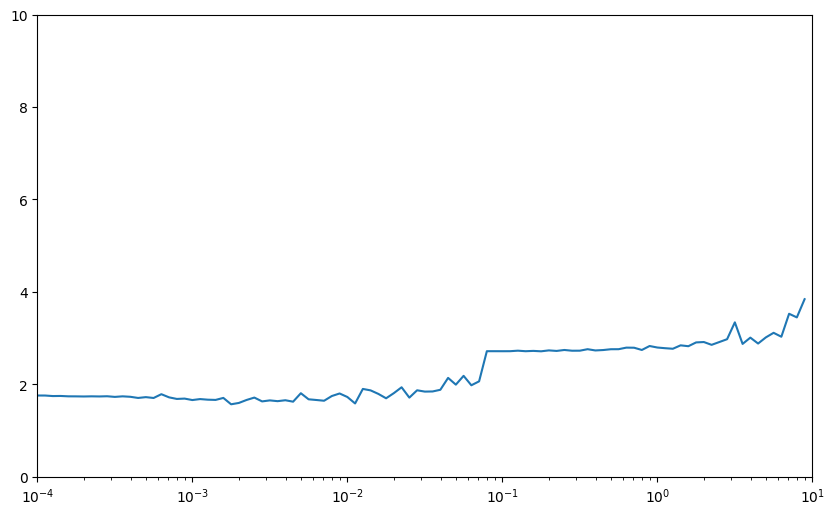

In [24]:
lrs = lr_history.history["lr"]
loss = lr_history.history["loss"]

plt.figure(figsize=(10,6))
plt.semilogx(lrs, loss)
plt.axis([1e-4, 10, 0, 10])

In [29]:
min_loss_index = np.argmin(loss)
min_lr = lrs[min_loss_index]
print(min_lr)

0.0017782794


## Compiling the model

Now that we have trained the model while varying the learning rate, it is time to do the actual training that will be used to forecast the time series.


In [31]:
tuned_model = create_model()
learning_rate = 1.7e-3

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

tuned_model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

history = tuned_model.fit(train_set, epochs=100)

Epoch 1/100
77/77 [==============================] - 26s 251ms/step - loss: 4.6637
Epoch 2/100
77/77 [==============================] - 21s 270ms/step - loss: 2.2123
Epoch 3/100
77/77 [==============================] - 19s 248ms/step - loss: 1.9136
Epoch 4/100
77/77 [==============================] - 21s 265ms/step - loss: 1.8561
Epoch 5/100
77/77 [==============================] - 20s 251ms/step - loss: 1.8692
Epoch 6/100
77/77 [==============================] - 21s 260ms/step - loss: 1.8295
Epoch 7/100
77/77 [==============================] - 21s 269ms/step - loss: 1.9148
Epoch 8/100
77/77 [==============================] - 21s 265ms/step - loss: 1.7972
Epoch 9/100
77/77 [==============================] - 20s 257ms/step - loss: 1.7794
Epoch 10/100
77/77 [==============================] - 20s 252ms/step - loss: 1.7613
Epoch 11/100
77/77 [==============================] - 21s 269ms/step - loss: 1.8065
Epoch 12/100
77/77 [==============================] - 21s 265ms/step - loss: 1.7873
E

## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this you can use the `compute_metrics` function.

In [32]:
def compute_metrics(true_series, predictions):
  mae = tf.keras.metrics.MAE(true_series,predictions)
  mse = tf.keras.metrics.MSE(true_series,predictions)

  return mae, mse

## Faster model forecasts


In [35]:
def model_forecast(model, series, window_size):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(size=window_size, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda w:w.batch(window_size))
  dataset = dataset.batch(32).prefetch(1)
  forecast = model.predict(dataset)

  return forecast

113/113 [==============================] - 12s 96ms/step


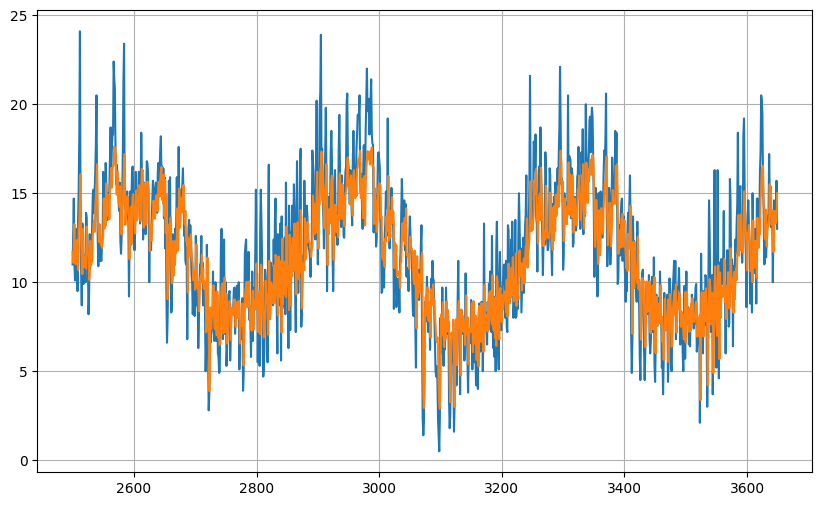

In [36]:
#Compute the forecasts
forecast_series = model_forecast(tuned_model, series, WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
forecast_series = forecast_series[SPLIT_TIME-WINDOW_SIZE:-1]

# Plot the forecast
plot_series(time_valid, (series_valid, forecast_series))



In [37]:
mse, mae = compute_metrics(series_valid, forecast_series)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 1.78, mae: 5.22 for forecast
